In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from torch_optimizer.radam import RAdam

from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomRotate90, RGBShift, ChannelShuffle)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

# Configuration

In [3]:
CFG = {
    "save_prev"     : True,
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_img"     : '../input/dog-breed-identification/train/',
    "input_path"    : '../input/dog-breed-identification/labels.csv',
    "output_path"   : './',
    "save_name"     : "dogbreed_swin_ce2",
    "model"         : 'swin_large_patch4_window7_224_in22k',
    "size"          : 224,
    "batch_size"    : 32,
    "epochs"        : 10,
    'T_0'           : 20,
    "lr"            : 0.001,
    'momentum'      : 0.9,
    'weight_decay'  : 1e-4,
    "accum_iter"    : 1,
    'early_stopping': 3,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'save_prev': True,
 'seed': 42,
 'device': 'cuda:0',
 'input_img': '../input/dog-breed-identification/train/',
 'input_path': '../input/dog-breed-identification/labels.csv',
 'output_path': './',
 'save_name': 'dogbreed_swin_ce2',
 'model': 'swin_large_patch4_window7_224_in22k',
 'size': 224,
 'batch_size': 32,
 'epochs': 10,
 'T_0': 20,
 'lr': 0.001,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'accum_iter': 1,
 'early_stopping': 3,
 'verbose_step': 1,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
if CFG['save_prev']:
    !cp ../input/petfinder-dogbreed-cnn-models/dogbreed_swin_binary.pt ./dogbreed_swin_ce.pt

# Load data

In [6]:
df_train  = pd.read_csv(CFG['input_path'])
target, _ = pd.factorize(df_train['breed'], sort=True)
df_train['target'] = target
df_train["path"]   = [f"{CFG['input_img']}{i}.jpg" for i in df_train.id]

print(df_train.shape)
df_train.head(2)

(10222, 4)


,id,breed,target,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,../input/dog-breed-identification/train/000bec...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,../input/dog-breed-identification/train/001513...


# Define model

In [7]:
class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 120)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [8]:
class PetFinderDataset(Dataset):
    def __init__(self, df, transforms=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.train        = train
        self.output_label = output_label
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img  = get_img(self.df.loc[index].path)
        y    = torch.from_numpy(np.array(self.df.loc[index].target))
        if self.transforms:
            img = self.transforms(image=img)['image']
        if self.output_label:
            return img, y
        return img

In [9]:
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        HorizontalFlip(p=0.5),
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)
  
def get_valid_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

In [10]:
def prepare_dataloader(train, valid):
    train_ds = PetFinderDataset(train, transforms=get_train_transforms())
    valid_ds = PetFinderDataset(valid, transforms=get_valid_transforms())
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['batch_size'],
                                               drop_last=False,
                                               pin_memory=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    val_loader = torch.utils.data.DataLoader(valid_ds,
                                             batch_size=CFG['batch_size'],
                                             pin_memory=False,
                                             shuffle=False,
                                             num_workers=CFG['num_workers'])
    return train_loader, val_loader

In [11]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    mean_loss    = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, scores) in pbar:
        imgs   = imgs.to(device).float()
        scores = scores.to(device).long()

        with autocast():
            img_preds = model(imgs)
            loss = loss_fn(img_preds, scores) / CFG['accum_iter']
        scaler.scale(loss).backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01
        mean_loss += loss.item()

        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() 
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    return mean_loss/len(train_loader)
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum   = 0
    sample_num = 0
    img_preds_all = []
    img_truth_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, scores) in pbar:
        imgs   = imgs.to(device)
        scores = scores.to(device).long()
        
        img_preds = model(imgs)
        img_preds_all += [np.argmax(img_preds.detach().cpu().numpy(), 1)]
        img_truth_all += [scores.detach().cpu().numpy()]
        
        loss = loss_fn(img_preds, scores)
        loss_sum   += loss.item()*scores.shape[0]
        sample_num += scores.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
            
    img_preds_all = np.concatenate(img_preds_all)
    img_truth_all = np.concatenate(img_truth_all)
    acc = np.mean(img_preds_all==img_truth_all)
    print('validation acc = {:.6f}'.format(acc))    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
    return acc, loss_sum/sample_num,  [img_preds_all, img_truth_all]

In [12]:
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       # Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

# Run training

In [13]:
train, valid = train_test_split(df_train, test_size=0.3, random_state=CFG["seed"])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

print(train.shape, valid.shape)

(7155, 4) (3067, 4)


In [14]:
train_loader, val_loader = prepare_dataloader(train, valid)

not_improved_cnt = 0
best_acc   = 0
best_epoch = 0
histories  = {}

device    = torch.device(CFG['device'])
model     = SwinModel(CFG["model"])
model.to(device)
scaler    = GradScaler()
optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])
#optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
#scheduler = None
loss      = nn.CrossEntropyLoss().to(device)

for epoch in range(CFG['epochs']):
    train_loss = train_one_epoch(epoch, model, loss, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

    with torch.no_grad():
        acc, valid_loss, hist = valid_one_epoch(epoch, model, loss, val_loader, device, scheduler=None, schd_loss_update=False)
    histories[epoch] = [train_loss, valid_loss, acc, hist]
        
    if best_acc < acc:
        print('Best model will be saved to output path after completing this fold')
        best_model = copy.deepcopy(model)
        best_acc   = acc
        best_epoch = epoch
        not_improved_cnt = 0
    elif CFG['early_stopping'] == not_improved_cnt:
        print("Met early stopping.")
        break
    else:
        not_improved_cnt += 1

torch.save(best_model.state_dict(), f"{CFG['output_path']}{CFG['save_name']}.pt")

del model, optimizer, train_loader, val_loader, scaler
torch.cuda.empty_cache()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth
epoch 0 loss: 0.9272: 100%|██████████| 96/96 [00:44<00:00,  2.14it/s]

validation acc = 0.783828
Best model will be saved to output path after completing this fold



epoch 1 loss: 0.4915: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]

validation acc = 0.845452
Best model will be saved to output path after completing this fold



epoch 2 loss: 0.4631: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]


validation acc = 0.850994
Best model will be saved to output path after completing this fold


epoch 3 loss: 0.4256: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]

validation acc = 0.865993
Best model will be saved to output path after completing this fold



epoch 4 loss: 0.4550: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]

validation acc = 0.852625



epoch 5 loss: 0.4172: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]

validation acc = 0.868601
Best model will be saved to output path after completing this fold



epoch 6 loss: 0.4246: 100%|██████████| 96/96 [00:44<00:00,  2.14it/s]

validation acc = 0.864689



epoch 7 loss: 0.4046: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]

validation acc = 0.868275



epoch 8 loss: 0.4050: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]

validation acc = 0.872840
Best model will be saved to output path after completing this fold



epoch 9 loss: 0.4046: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]


validation acc = 0.872188


Best accuracy was 0.8728399087055755


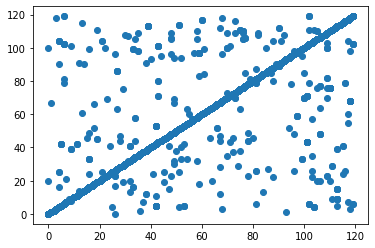

In [15]:
print(f"Best accuracy was {histories[best_epoch][2]}")

# Plot last epoch result
plt.scatter(x=hist[0], y=hist[1])